# 가설: 리모델링 여부가 주택 가격에 영향을 미칠까?

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. 데이터 전처리

## 1-1. 데이터 임포트

In [2]:
df = pd.read_csv("1st_train_mdf.csv")

## 1-2. 데이터 전처리: 누락값의 처리

- 누락값은 아니지만 id는 sale price와 상관관계를 파악하는 데 필요없다고 판단, 제거하였습니다.

In [3]:
df = df.drop(['Id'], axis = 1)

- 누락값 확인

In [4]:
null_data= df.isnull().sum()
df.isnull().sum()[df.isnull().sum()>0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

- 데이터의 80% 이상(1000개)이 결측치인 데이터들은 삭제
- 해당 데이터의 누락 원인: 해당 시설 None

In [5]:
null_data[null_data.values > 1000].index

Index(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')

In [6]:
df.drop(["Alley", "PoolQC", "Fence", "MiscFeature"], axis = 1,inplace = True)

- 259(17.7%)인 데이터 LotFrontage는 중위값으로 채워줌
- 누락 원인: 알 수 없음

In [7]:
df.LotFrontage.fillna(df.LotFrontage.median(), inplace=True)

- 수치형 데이터는 0, 범주형 데이터는 'None'으로 처리
- 누락 원인: 벽돌외장 면적 0, None

In [8]:
df.loc[df.MasVnrArea.isnull(),['MasVnrArea','MasVnrType']]

,MasVnrArea,MasVnrType
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


In [9]:
df.MasVnrArea.fillna(0, inplace=True)  
df.MasVnrType.fillna('None', inplace=True) 

- 누락원인: 해당 시설 None

In [10]:
df.GarageType.fillna('None', inplace=True)
df.GarageYrBlt.fillna('None', inplace=True)
df.GarageFinish.fillna('None', inplace=True)
df.GarageQual.fillna('None', inplace=True)
df.GarageCond.fillna('None', inplace=True)

In [11]:
df.BsmtQual.fillna('None', inplace=True)
df.BsmtCond.fillna('None', inplace=True)
df.BsmtExposure.fillna('None', inplace=True)
df.BsmtFinType1.fillna('None', inplace=True)
df.BsmtFinType2.fillna('None', inplace=True)
df.FireplaceQu.fillna('None', inplace=True)

- 제일 빈도가 큰값(Top)인 SBrkr으로 처리
- 누락원인: 알 수 없음

In [12]:
df.Electrical.fillna("SBrkr", inplace=True)

- 결측값이 더 이상 없는 것 확인

In [13]:
df.isnull().sum()[df.isnull().sum()>0]

Series([], dtype: int64)

## 1-3. Visualization

**중요변수 확인**

<AxesSubplot:>

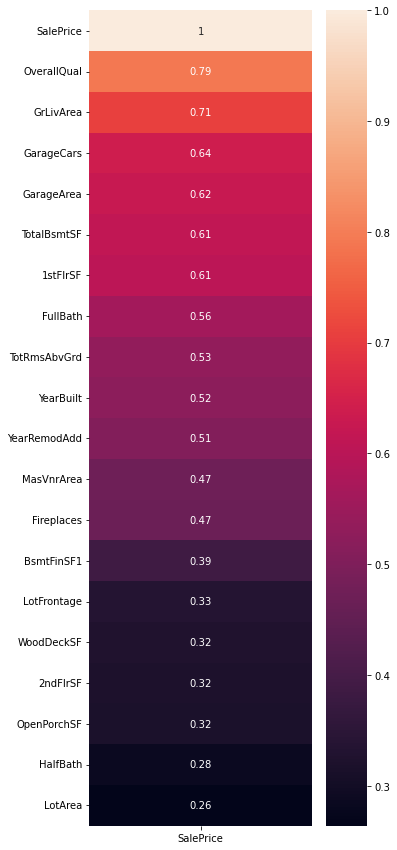

In [14]:
corr_matrix = df.corr()
plt.figure(figsize=(5,15))
sns.heatmap(corr_matrix[['SalePrice']].sort_values(by=['SalePrice'],
                                ascending=False).head(20),annot=True)

- YearBuilt, YearRemod가 0.59, 0.57의 상관관계로 해당 데이터에서 높은 상관관계를 보여주고 있습니다.

<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

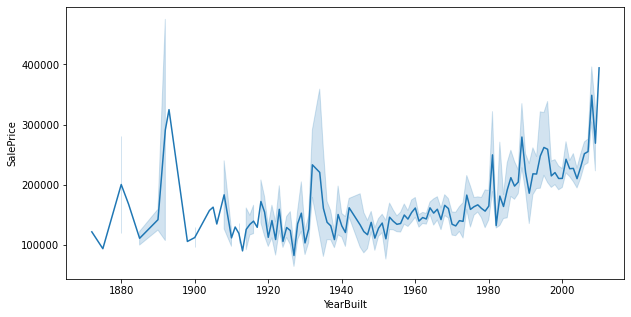

In [15]:
plt.figure(figsize = [10, 5])
sns.lineplot(data=df, x='YearBuilt', y='SalePrice')

<AxesSubplot:xlabel='YearRemodAdd', ylabel='SalePrice'>

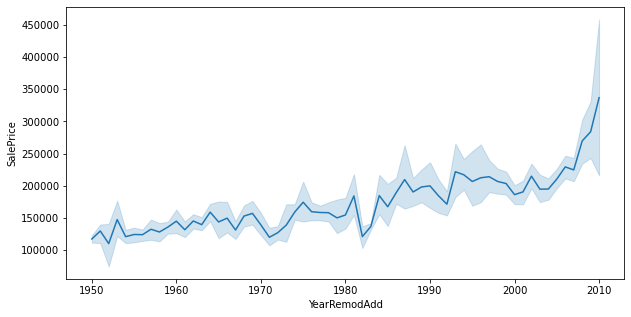

In [16]:
plt.figure(figsize = [10, 5])
sns.lineplot(data=df, x='YearRemodAdd', y='SalePrice')

- 기울기가 높은 우상향 그래프는 아니나, 어느 정도의 상관관계는 보여주고 있습니다.

In [17]:
bins = [0, 1959, 1979, 1999, 2019]
group_names = ['~1950s', '1960s~1970s', '1980s~1990s', '2000s~2010s']

In [18]:
df['YrSold'].describe()

count    1460.000000
mean     2007.815753
std         1.328095
min      2006.000000
25%      2007.000000
50%      2008.000000
75%      2009.000000
max      2010.000000
Name: YrSold, dtype: float64

- 리모델링 여부 관계를 확인하면서 '언제 팔렸는지'의 변수또한 중요하다고 생각했는데
- 년도들이 그리 차이나지 않아서(1년 4개월정도) 고려대상에서 제외하였습니다.

In [19]:
year_cats = pd.cut(df['YearRemodAdd'], bins, labels=group_names)
df[['YearBuilt', 'YearRemodAdd']]

,YearBuilt,YearRemodAdd
0,2003,2003
1,1976,1976
2,2001,2002
3,1915,1970
4,2000,2000
...,...,...
1455,1999,2000
1456,1978,1988
1457,1941,2006
1458,1950,1996


- YearBuilt, YearRemodAdd의 년도가 동일한 경우: No-Remod
- 년도가 동일하지 않은 경우: Yes-Remod

In [20]:
df['IsRemodel'] = df[['YearBuilt', 'YearRemodAdd']].apply(lambda x: "NoRemod" if x[0] == x[1] 
                                                          else "YesRemod", axis = 1)

**IsRemodel; NoRemod, YesRemod의 개수**

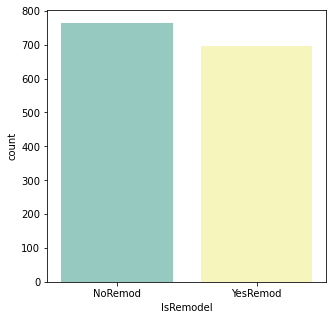

In [21]:
fig, axes = plt.subplots(figsize=(5,5))
sns.countplot(x = df['IsRemodel'], palette="Set3")
plt.show()

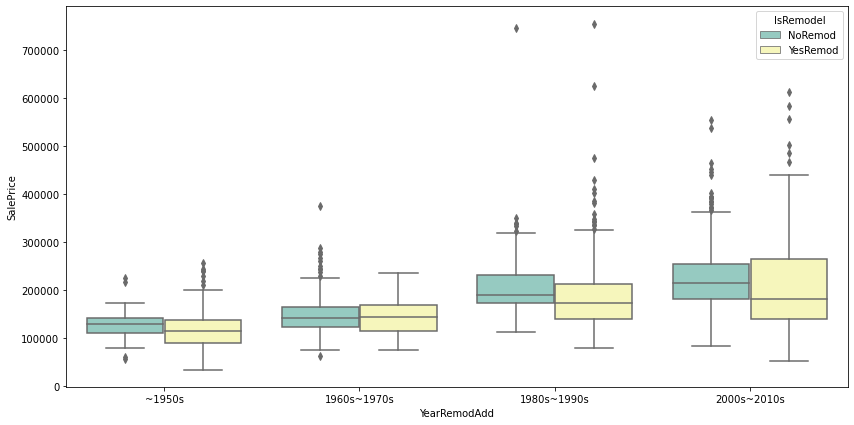

In [22]:
plt.figure(figsize=(14,7))
plt.rc('axes', axisbelow = True)
sns.boxplot(data=df, y="SalePrice", x=year_cats, palette = "Set3", hue = 'IsRemodel')
plt.show()

## 1-4. 원-핫 인코딩

In [23]:
df = pd.get_dummies(df)

## 1-5. 로그변환 

- SalePrice 데이터를 보면 왼쪽으로 치우쳐 있고, 정규분포에서 많이 벗어난 모습을 볼 수 있습니다.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


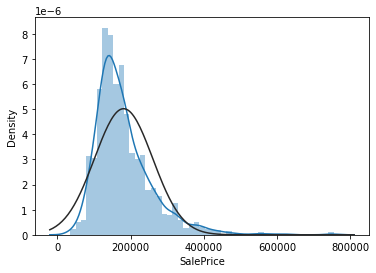

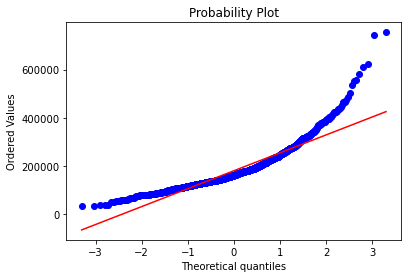

In [24]:
import scipy.stats as st
sns.distplot(df['SalePrice'], fit=st.norm)
fig = plt.figure()
res = st.probplot(df['SalePrice'], plot=plt)

- 로그 변환 후, 정규분포와 빨간 사선에 모두 부합한 모습

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


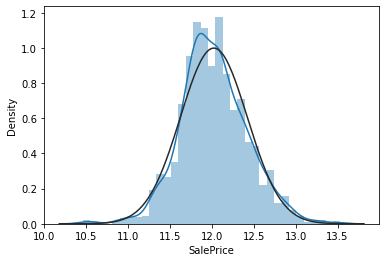

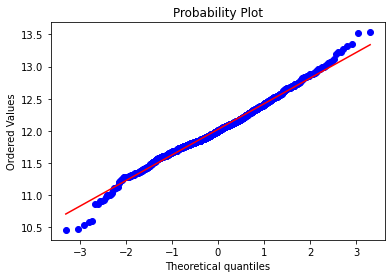

In [25]:
df['SalePrice'] = np.log(df['SalePrice'])
sns.distplot(df['SalePrice'], fit=st.norm)
fig = plt.figure()
res = st.probplot(df['SalePrice'], plot=plt)

## 1-6. 데이터세트를 훈련용, 테스트용으로 분할

In [26]:
# trainset, testset 분리
from sklearn.model_selection import train_test_split
X = df.drop('SalePrice', axis = 1)
y = df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42)

# 2. 예측 모델 구현

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error # MSE
from sklearn.model_selection import cross_val_score

## 2-1. 선형 회귀

In [28]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lin_scores = cross_val_score(lin_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10, n_jobs=-1)
lin_rmse = np.sqrt((-lin_scores).mean())
lin_rmse

13712.537839819337

## 2-2. 규제모델 적용

In [29]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

### Ridge(릿지)

In [30]:
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
ridge_scores = cross_val_score(ridge_reg, X_train, y_train, scoring = "neg_mean_squared_error", cv = 5 )
ridge_reg_rmse = np.sqrt((-ridge_scores).mean())
ridge_reg_rmse

0.15741288245359034

### Lasso(라쏘)

In [31]:
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)
lasso_scores = cross_val_score(lasso_reg, X_train, y_train, scoring = "neg_mean_squared_error", cv=10, n_jobs=-1)
lasso_rmse = np.sqrt(-lasso_scores).mean()
lasso_rmse

0.1965057828911776

### ElasticNet(엘라스틱넷)

In [32]:
elastic_reg = ElasticNet()
elastic_reg.fit(X_train, y_train)
elastic_scores = cross_val_score(elastic_reg, X_train, y_train, scoring = "neg_mean_squared_error", cv=10, n_jobs=-1)
elastic_rmse = np.sqrt(-elastic_scores).mean()
elastic_rmse

0.19069598691213752

## 2-3 선형 회귀계수 시각화

In [33]:
def get_top_bottom_coef(model):
    # coef_ > Series 생성 
    coef = pd.Series(model.coef_, index=X.columns)    
    # 상위 10개 , 하위 10개 회귀계수 Series 추출하여 반환.
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)

    return coef_high, coef_low

def visualize_coefficient(models):

    # subplot 생성
    fig, axs = plt.subplots(figsize=(15,5), nrows=1, ncols=len(models), constrained_layout=True)
    # 모델별 회귀계수 시각화
    for i_num, model in enumerate(models):
        # get_top_bottom_coef 함수 호출 > concat으로 결합. 
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high , coef_low], axis=0)
        
        axs[i_num].set_title(model.__class__.__name__+' Coeffiecents')         # title
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num]) # barplot

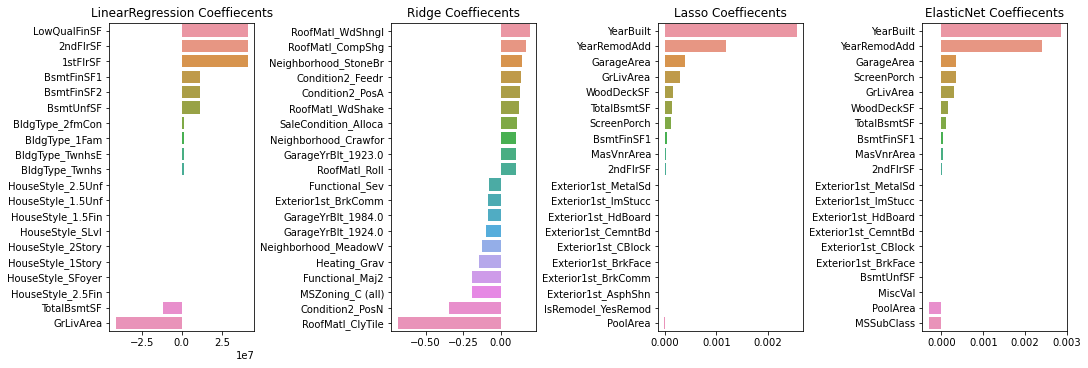

In [34]:
models = [lin_reg, ridge_reg, lasso_reg, elastic_reg]
visualize_coefficient(models)

- Lasso, ElasticNet에서 YearBuilt, YearRemodAdd가 주택가격에 영향을 미치는 변수 top2로 나타났습니다

## 2-4. RandomForest(랜덤포레스트)

In [35]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)
rf_scores = cross_val_score(rf_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10, n_jobs=-1)
rf_rmse = np.sqrt((-rf_scores).mean())
rf_rmse

0.14655598653186508

## 2-5. DecisionTree(의사결정트리)

In [36]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)
tree_scores = cross_val_score(tree_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10, n_jobs=-1)
tree_rmse = np.sqrt((-tree_scores).mean())
tree_rmse

0.21410793403446413

## 2-6. XGB

In [37]:
import xgboost as xgb
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
xgb_scores = cross_val_score(xgb_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10, n_jobs=-1)
xgb_rmse = np.sqrt((-xgb_scores).mean())
xgb_rmse

0.1403799882028546

# 3. 파라미터 튜닝

## 3-1. 그리드탐색(GridSearch)

In [38]:
from sklearn.model_selection import GridSearchCV

### Ridge, Lasso, ElasticNet

In [39]:
params = {'alpha':[0.0001,0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,12,15,20,25,30]}
models = [ridge_reg,lasso_reg, elastic_reg]

for model in models:
    grid = GridSearchCV(model, param_grid = params, cv=10, scoring = 'neg_mean_squared_error',n_jobs=-1)
    grid.fit(X,y)
    rmse = np.sqrt(-1*grid.best_score_)
    print('{0} 10 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,rmse, grid.best_params_))

Ridge 10 CV 시 최적 평균 RMSE 값: 0.14138500155873734, 최적 alpha:{'alpha': 15}
Lasso 10 CV 시 최적 평균 RMSE 값: 0.14258860975561335, 최적 alpha:{'alpha': 0.001}
ElasticNet 10 CV 시 최적 평균 RMSE 값: 0.14026914972336943, 최적 alpha:{'alpha': 0.001}


### RandomForest

In [40]:
param_grid = {'n_estimators' : [10, 100, 200],
              'max_depth' : [6, 12, 15],
              'min_samples_leaf' : [4, 8, 12],
              'min_samples_split' : [8, 15, 18]
}
rf_grid_search = GridSearchCV(rf_reg, param_grid, scoring="neg_mean_squared_error", cv=10, n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [6, 12, 15],
                         'min_samples_leaf': [4, 8, 12],
                         'min_samples_split': [8, 15, 18],
                         'n_estimators': [10, 100, 200]},
             scoring='neg_mean_squared_error')

In [41]:
for mean_score, params in zip(rf_grid_search.cv_results_['mean_test_score'], rf_grid_search.cv_results_['params']):
    print(np.sqrt(-rf_scores), params)

[0.10213024 0.15849793 0.12615412 0.18730496 0.1666507  0.18456055
 0.14481862 0.13475867 0.12785079 0.10451399] {'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 10}
[0.10213024 0.15849793 0.12615412 0.18730496 0.1666507  0.18456055
 0.14481862 0.13475867 0.12785079 0.10451399] {'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 100}
[0.10213024 0.15849793 0.12615412 0.18730496 0.1666507  0.18456055
 0.14481862 0.13475867 0.12785079 0.10451399] {'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 200}
[0.10213024 0.15849793 0.12615412 0.18730496 0.1666507  0.18456055
 0.14481862 0.13475867 0.12785079 0.10451399] {'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 15, 'n_estimators': 10}
[0.10213024 0.15849793 0.12615412 0.18730496 0.1666507  0.18456055
 0.14481862 0.13475867 0.12785079 0.10451399] {'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 15, 'n_estimators': 100}
[0.1021302

In [42]:
rf_grid_search.best_params_

{'max_depth': 12,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 200}

### best
[0.10423401 0.15716388 0.12835064 0.18678672 0.16342983 0.18678436
 0.14237225 0.1325993  0.13015102 0.0988073 ] {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 200}

In [43]:
(0.10423401+ 0.15716388+ 0.12835064+ 0.18678672 +0.16342983 +0.18678436+0.14237225+0.1325993+0.13015102+0.0988073)/10

0.143067931

**0.145->0.143**

### DecisionTree

In [44]:
tree_param_grid = {'max_depth':[6,8,10], 
              'min_samples_leaf':[5,10,20]
             }

In [45]:
tree_grid_search = GridSearchCV(tree_reg, tree_param_grid, scoring="neg_mean_squared_error",cv=10, n_jobs=-1)
tree_grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [6, 8, 10],
                         'min_samples_leaf': [5, 10, 20]},
             scoring='neg_mean_squared_error')

In [46]:
for mean_score, params in zip(tree_grid_search.cv_results_['mean_test_score'], tree_grid_search.cv_results_['params']):
    print(np.sqrt(-tree_scores), params)

[0.18830656 0.24083471 0.19026145 0.26548216 0.20071527 0.24894593
 0.1946523  0.19450201 0.22447241 0.17295101] {'max_depth': 6, 'min_samples_leaf': 5}
[0.18830656 0.24083471 0.19026145 0.26548216 0.20071527 0.24894593
 0.1946523  0.19450201 0.22447241 0.17295101] {'max_depth': 6, 'min_samples_leaf': 10}
[0.18830656 0.24083471 0.19026145 0.26548216 0.20071527 0.24894593
 0.1946523  0.19450201 0.22447241 0.17295101] {'max_depth': 6, 'min_samples_leaf': 20}
[0.18830656 0.24083471 0.19026145 0.26548216 0.20071527 0.24894593
 0.1946523  0.19450201 0.22447241 0.17295101] {'max_depth': 8, 'min_samples_leaf': 5}
[0.18830656 0.24083471 0.19026145 0.26548216 0.20071527 0.24894593
 0.1946523  0.19450201 0.22447241 0.17295101] {'max_depth': 8, 'min_samples_leaf': 10}
[0.18830656 0.24083471 0.19026145 0.26548216 0.20071527 0.24894593
 0.1946523  0.19450201 0.22447241 0.17295101] {'max_depth': 8, 'min_samples_leaf': 20}
[0.18830656 0.24083471 0.19026145 0.26548216 0.20071527 0.24894593
 0.1946523 

In [47]:
tree_grid_search.best_params_

{'max_depth': 10, 'min_samples_leaf': 10}

### best
[0.18794818 0.20906149 0.20137067 0.25688619 0.19668767 0.23936752
 0.17862833 0.18631085 0.21861528 0.17315969] {'max_depth': 10, 'min_samples_leaf': 10}

In [48]:
(0.18794818 +0.20906149 +0.20137067+ 0.25688619 +0.19668767 +0.23936752
+ 0.17862833+ 0.18631085+ 0.21861528+ 0.17315969)/10

0.204803587

**0.206 -> 0.2048**
성능이 생각보다 좋진 않았습니다...

### XGB

In [49]:
xgb_param_grid = {'learning_rate': [1,0.1,0.01],
              'n_estimators': [100, 200, 500],
              'max_depth' : [1,5,10]}

In [50]:
xgb_grid_search = GridSearchCV(xgb_reg, xgb_param_grid, scoring="neg_mean_squared_error",cv=10, n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None,...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estima

In [51]:
for mean_score, params in zip(xgb_grid_search.cv_results_['mean_test_score'], xgb_grid_search.cv_results_['params']):
    print(np.sqrt(-xgb_scores), params)

[0.1018996  0.17373086 0.12572019 0.16765974 0.1369347  0.17185006
 0.13213541 0.13269362 0.14015889 0.09792181] {'learning_rate': 1, 'max_depth': 1, 'n_estimators': 100}
[0.1018996  0.17373086 0.12572019 0.16765974 0.1369347  0.17185006
 0.13213541 0.13269362 0.14015889 0.09792181] {'learning_rate': 1, 'max_depth': 1, 'n_estimators': 200}
[0.1018996  0.17373086 0.12572019 0.16765974 0.1369347  0.17185006
 0.13213541 0.13269362 0.14015889 0.09792181] {'learning_rate': 1, 'max_depth': 1, 'n_estimators': 500}
[0.1018996  0.17373086 0.12572019 0.16765974 0.1369347  0.17185006
 0.13213541 0.13269362 0.14015889 0.09792181] {'learning_rate': 1, 'max_depth': 5, 'n_estimators': 100}
[0.1018996  0.17373086 0.12572019 0.16765974 0.1369347  0.17185006
 0.13213541 0.13269362 0.14015889 0.09792181] {'learning_rate': 1, 'max_depth': 5, 'n_estimators': 200}
[0.1018996  0.17373086 0.12572019 0.16765974 0.1369347  0.17185006
 0.13213541 0.13269362 0.14015889 0.09792181] {'learning_rate': 1, 'max_depth'

In [52]:
xgb_grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}

### best
[0.1018996  0.17373086 0.12572019 0.16765974 0.1369347  0.17185006
 0.13213541 0.13269362 0.14015889 0.09792181] {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}

In [53]:
(0.1018996 + 0.17373086 +0.12572019 +0.16765974 +0.1369347  +0.17185006
 +0.13213541+ 0.13269362+ 0.14015889+ 0.0979218)/10

0.138070487

**0.140 -> 0.138** 성능이 제일 좋았습니다!!

# 4. 검증

In [54]:
import statsmodels.api as sm

In [61]:
#model = sm.OLS.from_formula("SalePrice ~ YearBuilt + YearRemodAdd + IsRemodel_NoRemod + IsRemodel_YesRemod", data=df)
#X_train=sm.add_constant(X_train)
#model = sm.OLS(y_train, X_train).fit()
#model.summary()

In [60]:
X_train=sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     48.54
Date:                Sat, 04 Feb 2023   Prob (F-statistic):               0.00
Time:                        03:11:23   Log-Likelihood:                 1187.7
No. Observations:                1168   AIC:                            -1719.
Df Residuals:                     840   BIC:                            -58.64
Df Model:                         327                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.2772      0.613      2.084      0.037       0.074       2.480
MSSubClass               -0.0004      0.001     -0.709      0.479      -0.001       0.001
LotFrontage               0.0003      0.000      1.055      0.292      -0.000       0.001
LotArea                2.116e-06    6.9e-07      3.067      0.002    7.62e-07    3.47e-06
OverallQual               0.0395      0.006      6.922      0.000       0.028       0.051
OverallCond               0.0359      0.005      7.426      0.000       0.026       0.045
YearBuilt                 0.0019      0.000      4.442      0.000       0.001       0.003
YearRemodAdd              0.0011      0.000      3.174      0.002       0.000       0.002
MasVnrArea             2.683e-05   3.37e-05      0.797      0.426   -3.92e-05    9.29e-05
BsmtFinSF1             5.472e-05   1.57e-05      3.485      0.001    2.39e-05    8.55e-05
BsmtFinSF2             4.066e-05   3.29e-05      1.237      0.216   -2.38e-05       0.000
BsmtUnfSF              1.489e-06   1.52e-05      0.098      0.922   -2.83e-05    3.12e-05
TotalBsmtSF            9.687e-05   2.18e-05      4.445      0.000    5.41e-05       0.000
1stFlrSF               4.865e-05   3.73e-05      1.305      0.192   -2.45e-05       0.000
2ndFlrSF               5.269e-05   3.13e-05      1.682      0.093   -8.79e-06       0.000
LowQualFinSF           7.158e-05   8.41e-05      0.851      0.395   -9.35e-05       0.000
GrLivArea                 0.0002   3.34e-05      5.181      0.000       0.000       0.000
BsmtFullBath              0.0306      0.011      2.808      0.005       0.009       0.052
BsmtHalfBath              0.0136      0.017      0.799      0.425      -0.020       0.047
FullBath                  0.0107      0.012      0.864      0.388      -0.014       0.035
HalfBath                  0.0221      0.011      1.947      0.052      -0.000       0.044
BedroomAbvGr              0.0171      0.008      2.203      0.028       0.002       0.032
KitchenAbvGr             -0.0300      0.030     -0.994      0.321      -0.089       0.029
TotRmsAbvGrd             -0.0005      0.005     -0.096      0.924      -0.011       0.010
Fireplaces                0.0244      0.014      1.715      0.087      -0.004       0.052
GarageCars                0.0083      0.013      0.654      0.513      -0.017       0.033
GarageArea                0.0002   4.39e-05      3.797      0.000    8.06e-05       0.000
WoodDeckSF             9.227e-05   3.18e-05      2.905      0.004    2.99e-05       0.000
OpenPorchSF            2.177e-05   6.04e-05      0.361      0.719   -9.67e-05       0.000
EnclosedPorch             0.0001   7.02e-05      1.857      0.064   -7.44e-06       0.000
3SsnPorch                 0.0002      0.000      1.682      0.093   -3.16e-05       0.000
ScreenPorch            

## 4-1. 유의성 검정

: 실제 모집단의 특성이 설계한 모델과 전혀 맞지 않더라도, 관측된 데이터 내에서 우연히 맞은 것인지 아닌지를 통계 기법을 통해 검증하는 것을 말합니다.

```
                            coef    std err  t   P>|t|   [0.025   0.975] 
```

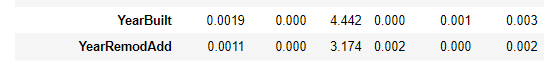

In [57]:
from IPython.display import Image
Image('images/Yearbuilt.png')

- 일반적으로 P-value가 0.05보다 작으면 모델이 통계적으로 유의하다고 판단합니다.
- 원래 가설 변수인 'YearBuilt'와 'YearRemodAdd'는 0.001보다 작은, 0.002의 값을 가지므로
- 본 변수 자체로는 통계적으로 유의미합니다.

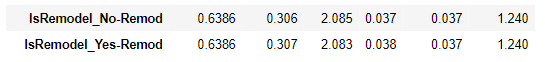

In [58]:
#No-Remod->NoRemod / Yes-Remod->YesRemod (변수부를때 오류가 생겨서 '-' 지웠습니다)
from IPython.display import Image
Image('images/IsRemodel.png')

- IsRemodel.NoRemod, IsRemodel_YesRemod 또한 0.037, 0.038을 값을 가지므로(<0.05)
- 신뢰할 수 있는 결과값이라 할 수 있습니다.

## 4-2. 설명력 검정

: 실제 주택가격을 해당 회귀 모델들로 얼마나 잘 설명하고 있는지를 말함. 이는 회귀 분석 결과에서 R-squared(R 제곱)에 해당하며, 일반적으로는 Adjusted R-squared를 사용

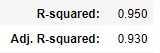

In [60]:
from IPython.display import Image
Image('images/R.png')

- 1에 가까울수록 회귀 모델이 추정한 가격과 실제 주택 가격의 차이가 작다는 것을 의미합니다.

## 4-3. 변수 영향력 분석

**Coef**

- YearBuilt는 0.0019, YearRemodAdd는 0.0011로 변수의 영향력이 작습니다.
- 오히려, IsRemodel의 여부가 둘 다 0.6386으로 높은 영향력을 보여줍니다.

**Std err**

- YearBuilt와 YearRemodAdd는 0의 값을 가지므로 해당 회귀 계수 추정치를 신뢰할 수 있습니다.
- IsRemodel의 변수들은 각각 0.306, 0.307으로 회귀 계수의 약 40%의 높은 값을 가지므로 본 변수의 회수 계수 추정치를 신뢰할 수 없습니다.

# 5. 결론

.....